In [1]:
import pickle
import pandas as pd
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('../data/bitMEX_ETHU18_5m_2018-06-19_2018-07-26.pkl')

In [3]:
para = {
    'ATR_window': 30,   # ATR计算：看前10根bar
    'ATR_multiplier': 10,    # 在 close +- 10倍ATR 处挂钓鱼单
    'leave_ATR_multiplier': 2.5,   # 在 close+- 2.5倍ATR处挂止盈单
    'wait_n_bars': 12,    # 12根bar（1小时）还不回来，平仓
    'rate': 0.01,
}

df['TR'] = df['high'] - df['close']
df.loc[df.volume == 0, 'TR'] = 0.0
df['ATR'] = df['TR'].rolling(para['ATR_window']).mean()
df['prev_ATR'] = df['ATR'].shift(1)
df
# df['ask_order_price'] = df['close'].shift(1) + para['ATR_multiplier'] * df['prev_ATR']   # 卖单
# df['bid_order_price'] = df['close'].shift(1) - para['ATR_multiplier'] * df['prev_ATR']   # 买单
df['prev_close'] = df['close'].shift(1)

# 挂钓鱼单的位置： 百分之一变动幅度
df['ask_order_price'] = df['prev_close'] * (1 + para['rate'])  # 卖单： pre_close * (1 + 0.001)
df['bid_order_price'] = df['prev_close'] * (1 - para['rate'])    # 买单：pre_close * (1 - 0.001)

# 止盈单位置：回来一半
df['ask_order_target_leave_price'] = df['prev_close'] * (1 + para['rate'] / 2)
df['bid_order_target_leave_price'] = df['prev_close'] * (1 - para['rate'] / 2)

df['hit_ask_order'] = df['high'] > df['ask_order_price']   # 高价卖单被吃掉
df['hit_bid_order'] = df['low'] < df['bid_order_price']   # 低价买单被吃掉

#df.head()

In [4]:
# 预期交易次数

print( df['hit_ask_order'].mean() )
print( df.loc[df['hit_ask_order']].__len__() )

print( df['hit_bid_order'].mean() )
print(df.loc[df['hit_bid_order']].__len__())

0.0022588235294117645
24
0.002823529411764706
30


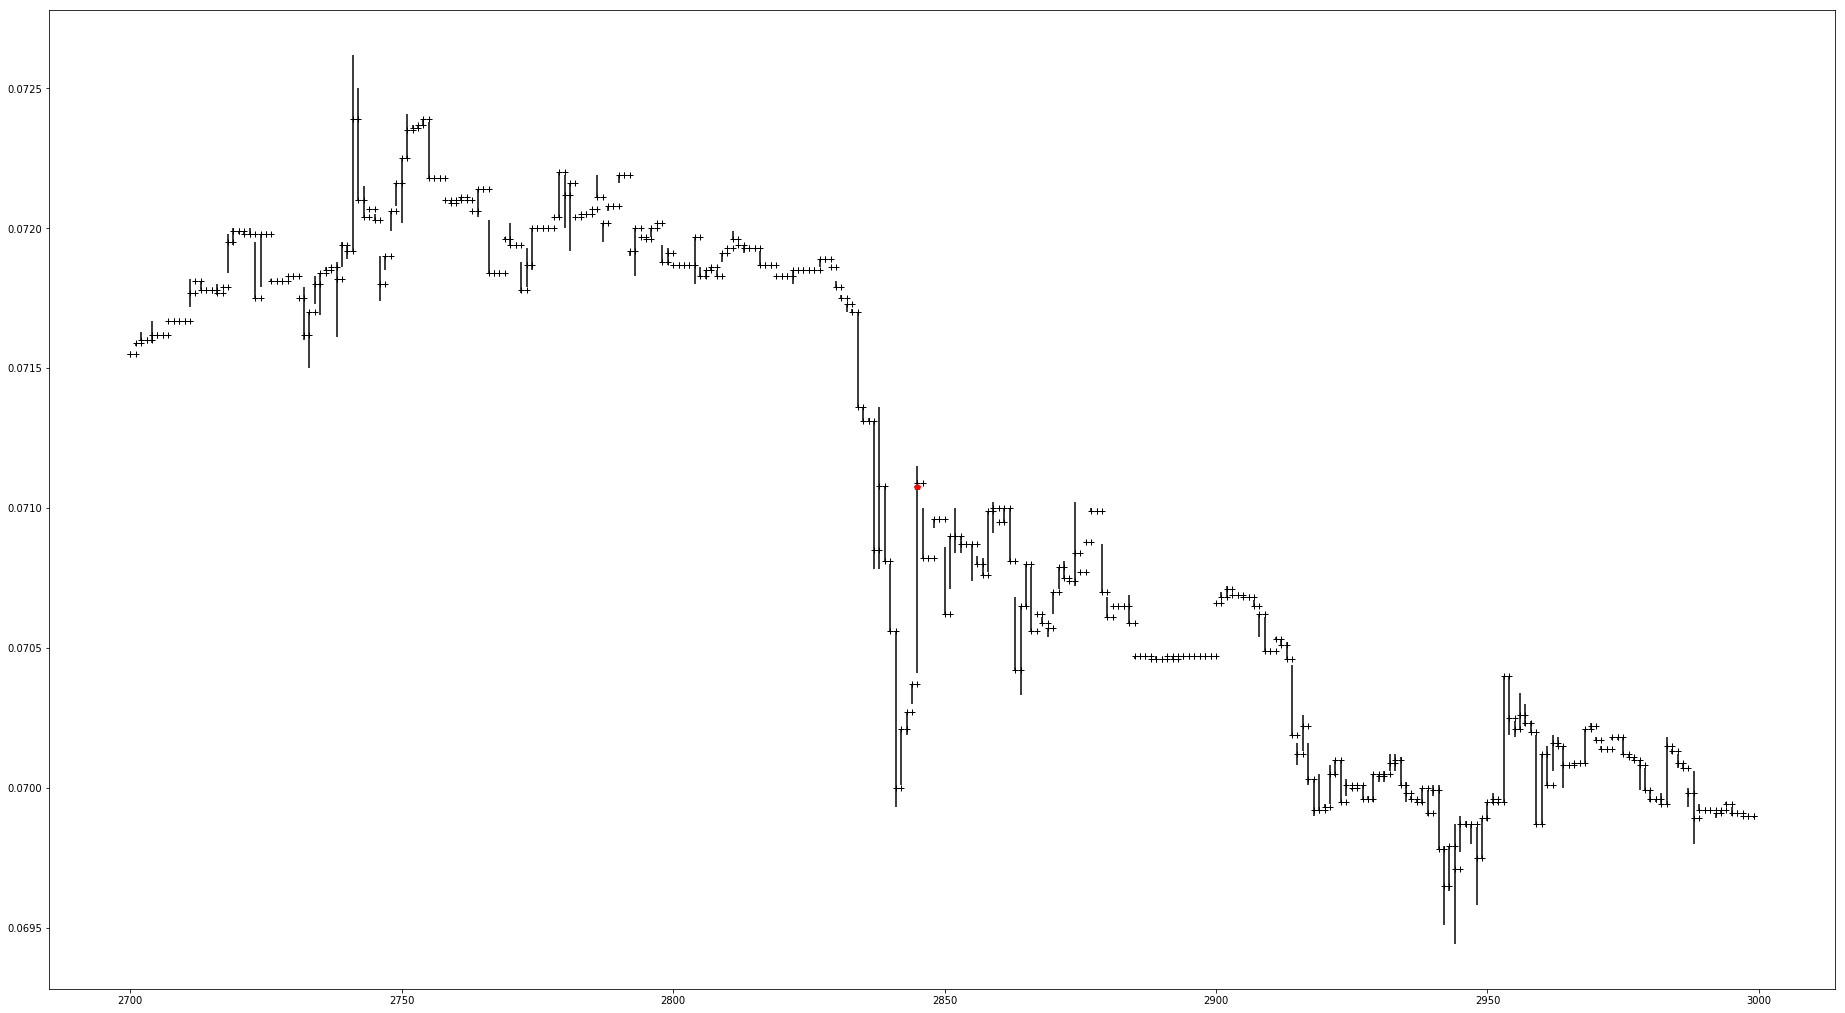

In [5]:
df_plt = df[2700:3000]

plt.figure(figsize=(32,18))
plt.vlines(x=df_plt.index, ymin=df_plt.low, ymax=df_plt.high)
plt.plot(df_plt.close, 'k+')
plt.plot(df_plt.open, 'k+')
plt.plot(df_plt.loc[df_plt.hit_ask_order, 'ask_order_price'], 'p', color='red')
plt.plot(df_plt.loc[df_plt.hit_bid_order, 'bid_order_price'], 'p', color='green')

In [6]:
len(df)

10625

In [7]:
## 回测

pos_history = []

current_position = {'pos': None}

def bar(column):
    return df.loc[cursor, column]

for cursor in df.index:

    if current_position['pos'] is not None:
        # 当前有仓位
        if current_position['pos'] == 'long':
            
            if max(bar('open'), bar('high')) > current_position['target_leave_price']:
                # if 触发止盈单
                current_position['leave'] = cursor
                current_position['leave_price'] = current_position['target_leave_price']
                current_position['conclusion'] = 'SUCCESS'
                # 添加仓位
                pos_history.append(current_position)
                # 清空
                current_position = {'pos':None}
            else:
                # 等待时间 += 1
                current_position['wait'] += 1
                if current_position['wait'] > para['wait_n_bars']:
                    # 如果超时，按照当前bar_close平仓
                    current_position['leave'] = cursor
                    current_position['leave_price'] = bar('close')
                    current_position['conclusion'] = 'FAIL'
                    # 添加仓位
                    pos_history.append(current_position)
                    # 清空
                    current_position = {'pos':None}
        elif current_position['pos'] == 'short':
            
            if min(bar('open'), bar('low')) < current_position['target_leave_price']:
                # if 触发止盈单
                current_position['leave'] = cursor
                current_position['leave_price'] = current_position['target_leave_price']
                current_position['conclusion'] = 'SUCCESS'
                # 添加仓位
                pos_history.append(current_position)
                # 清空
                current_position = {'pos':None}
            else:
                # 等待时间 += 1
                current_position['wait'] += 1
                if current_position['wait'] > para['wait_n_bars']:
                    # 如果超时，按照当前bar_close平仓
                    current_position['leave'] = cursor
                    current_position['leave_price'] = bar('close')
                    current_position['conclusion'] = 'FAIL'
                    # 添加仓位
                    pos_history.append(current_position)
                    # 清空
                    current_position = {'pos':None}
            
            
        else:
            raise Exception(9)
    else:
        # 当前无仓位    
        b_hit_ask = bar('hit_ask_order')
        b_hit_bid = bar('hit_bid_order')
        if b_hit_ask and not b_hit_bid:
            # ask被吃掉：pos = 'SHORT'
            current_position.update({'pos': 'short', 
                                     'enter': cursor, 
                                     'enter_price': bar('ask_order_price'), 
                                     'target_leave_price': bar('ask_order_target_leave_price'),
                                     'wait': 0})
        elif b_hit_bid and not b_hit_ask:
            # bid被吃掉：pos = 'LONG'
            current_position.update({'pos': 'long', 
                                     'enter': cursor, 
                                     'enter_price': bar('bid_order_price'), 
                                     'target_leave_price': bar('bid_order_target_leave_price'),
                                     'wait': 0})
        elif b_hit_ask and b_hit_bid:
            print('===== Warning: both bid and ask order has been hitted')

In [8]:
result_df = pd.DataFrame(pos_history)
result_df

,conclusion,enter,enter_price,leave,leave_price,pos,target_leave_price,wait
0,SUCCESS,37,0.080497,38,0.080098,short,0.080098,0
1,SUCCESS,46,0.080548,57,0.080149,short,0.080149,10
2,SUCCESS,510,0.081406,514,0.081003,short,0.081003,3
3,SUCCESS,891,0.077972,892,0.077586,short,0.077586,0
4,SUCCESS,918,0.075042,921,0.075421,long,0.075421,2
5,SUCCESS,923,0.074943,924,0.075321,long,0.075321,0
6,SUCCESS,999,0.076755,1000,0.077142,long,0.077142,0
7,FAIL,1020,0.074962,1033,0.076770,short,0.074591,13
8,SUCCESS,1537,0.074558,1539,0.074189,short,0.074189,1
9,FAIL,1585,0.074962,1598,0.074630,short,0.074591,13


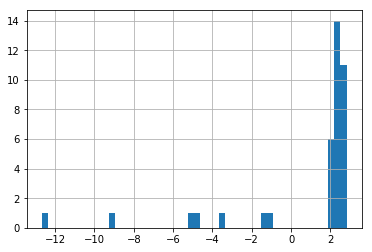

In [9]:
result_df.loc[result_df.pos == 'short', 'pos_integer'] = -1
result_df.loc[result_df.pos == 'long', 'pos_integer'] = 1

result_df['pnl'] = result_df.pos_integer * (result_df.leave_price - result_df.enter_price)

# plot (in USD)
(result_df.pnl * 7000).hist(bins = 50)

In [10]:
# 绝对收益： （仓位大小：1个ETH）
pnl_XBT = sum(result_df.pnl)

print("绝对收益：")
print(pnl_XBT, 'XBT')
print(pnl_XBT * 7000, 'USD')
print(pnl_XBT * 7000 * 7, 'RMB')

# 收益率
print('收益率：', sum(result_df.pnl) / df.vwap.mean())

# 交易次数：
print('交易次数:', len(result_df))

绝对收益：
0.0054232000000000585 XBT
37.96240000000041 USD
265.73680000000286 RMB
收益率： 0.07822475110930527
交易次数: 38


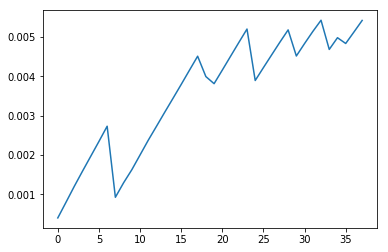

In [11]:
plt.plot(result_df.pnl.cumsum())

##  数据检查

In [12]:
df.query('high < low').__len__()   # high < low 没有

0

In [13]:
df.query('vwap > high | vwap < low | close > high | close < low').__len__()   # vwap, close 也都是在 [high, low] 中间

0

In [14]:
df.query('open > high | open < low').__len__()  # open有问题：不一定是在[high, low]区间内

3412

## 5分钟收益率分布

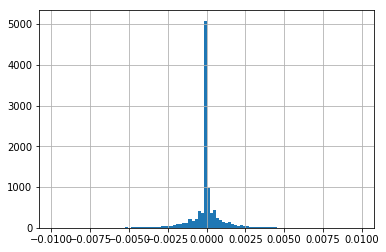

In [15]:
# 5m收益率分布： close / pre_close - 1

df['prev_close'] = df['close'].shift()
df['ret'] = df['close'] / df['prev_close'] - 1

df.ret[abs(df.ret) < 0.01].hist(bins = 100)

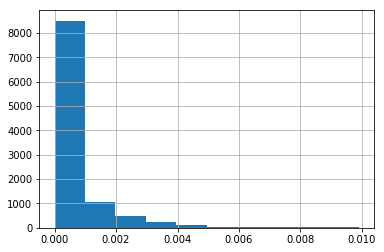

In [16]:
# # 5m收益率分布： (high - low) / close
df['range_ret'] = (df['high'] - df['low']) / df['close']
df.range_ret[df.range_ret < 0.01].hist()

## other

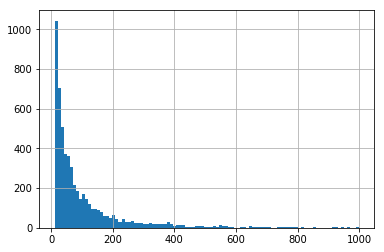

In [17]:
# 5分钟成交量 分布图 （考察策略容量）
df.volume[(df.volume < 1000) & (df.volume > 10)].hist(bins=100)

In [18]:
# 77% 的时间里，都有成交
(df.volume > 0).mean()

0.7707294117647059

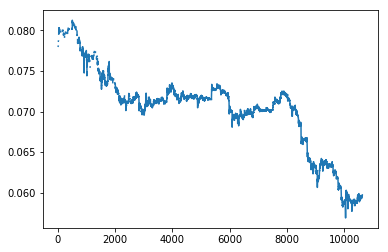

In [19]:
# 价格时序图
df.vwap.plot()